CG MSM from "primitive clustering" along rama-plot
====

In [1]:
import pyemma
pyemma.__version__

'2.1.1'

In [2]:
import os
%pylab inline
matplotlib.rcParams.update({'font.size': 12})

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
import msmbuilder
from msmbuilder.msm.ratematrix import ContinuousTimeMSM
import scipy
from msmtools.analysis.dense.decomposition import eigenvectors, eigenvalues
import operator
from scipy.optimize import curve_fit

Get the MSM
------

In [4]:
dtraj = np.load('dtraj_mss_5states_cored.npy')
dtrajs = []
for traj in range(dtraj.shape[0]):
    dtrajs.append( dtraj[traj] )

tica_lag = np.load('../../../../../TICA/tica_lag.npy')
tica_dim = np.load('../../../../../TICA/tica_dim.npy')
clust_dim = np.load('../../../../../TICA/clust_dim.npy')
nclust_max = np.load('../../../../../TICA/nclust_max.npy')
nclust = 509 # np.load('../../../TICA/nclust.npy')
Nprune = np.load('../../../../../TICA/Nprune.npy')

In [5]:
lags = tica_lag*np.linspace(1,100,100,dtype=int)
#core_lag = 16
#lags = core_lag*lags
#lags = np.linspace(tica_lag,8*tica_lag,tica_lag,dtype=int)
print lags
its_full = msm.timescales_msm(dtrajs, lags=lags, nits=3)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]


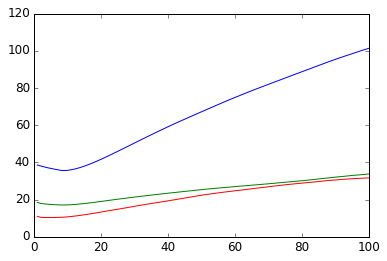

In [6]:
plt.plot(lags,its_full.timescales)
# plt.ylim([100,160])

In [7]:
lag_ind = 11
print its_full.lags[lag_ind]
Tmle = its_full.models[lag_ind].transition_matrix
mu = its_full.models[lag_ind].stationary_distribution

12


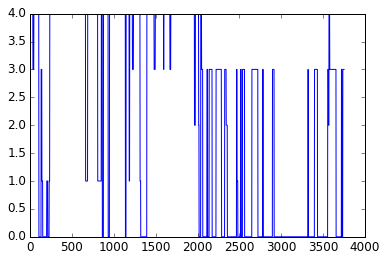

In [8]:
#plt.pcolor(its_full.models[0].transition_matrix)
#plt.hist(dtraj[0])
plt.plot(dtraj[0])

Get the dists
------

In [9]:
msd_proc = np.load('msd_mss_trajs_all.npy')
Nproc = msd_proc.shape[0]
#Ntraj = 1000
Nmss = msd_proc.shape[1]
wait_time_proc = np.load('wait_time_trajs_all.npy')
#for proc in range(Nproc):
#    trajs = np.split(np.arange(Nproc*(Ntraj/Nproc+1)),Nproc)[proc]
#    trajs = trajs[np.where(trajs<Ntraj)]
#    msd_proc.append( np.load('msd_mss_trajs_'+str(trajs[0])+'-'+str(trajs[-1])+'.npy') )
#    wait_time_proc.append( np.load('wait_time_trajs_'+str(trajs[0])+'-'+str(trajs[-1])+'.npy') )

In [10]:
msd = [[[] for x in range(Nmss)] for y in range(Nmss)]
wt = [[[] for x in range(Nmss)] for y in range(Nmss)]
for proc in range(Nproc):
    for imss in range(Nmss):
        for jmss in range(Nmss):
            for val in msd_proc[proc][imss][jmss]:
                msd[imss][jmss].append(val)
            for val in wait_time_proc[proc][imss][jmss]:
                wt[imss][jmss].append(val)

In [11]:
msd_hist = [[[] for x in range(Nmss)] for y in range(Nmss)]
msd_centers = [[[] for x in range(Nmss)] for y in range(Nmss)]
for imss in range(Nmss):
    for jmss in range(Nmss):
        if imss != jmss:
            msd_hist_tmp, msd_edges = np.histogram(msd[imss][jmss],bins=50,normed=1)
            msd_hist[imss][jmss] = msd_hist_tmp
            msd_centers[imss][jmss] = 0.5*(msd_edges[1:]+msd_edges[:-1]) 
            
wt_hist = [[[] for x in range(Nmss)] for y in range(Nmss)]
wt_centers = [[[] for x in range(Nmss)] for y in range(Nmss)]
for imss in range(Nmss):
    for jmss in range(Nmss):
        if imss != jmss:
            wt_hist_tmp, wt_edges = np.histogram(wt[imss][jmss],bins=50,normed=1)
            wt_hist[imss][jmss] = wt_hist_tmp
            wt_centers[imss][jmss] = 0.5*(wt_edges[1:]+wt_edges[:-1])

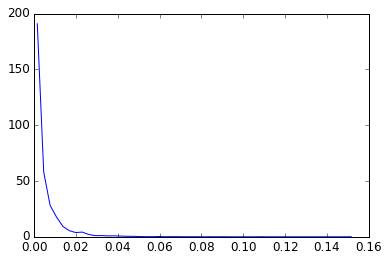

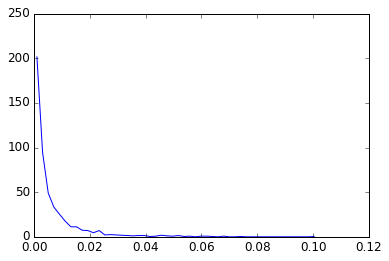

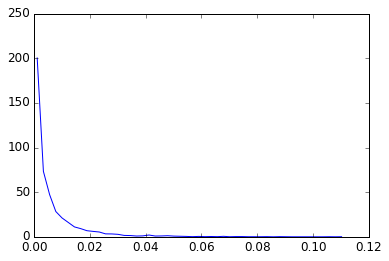

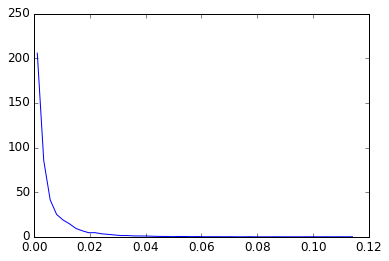

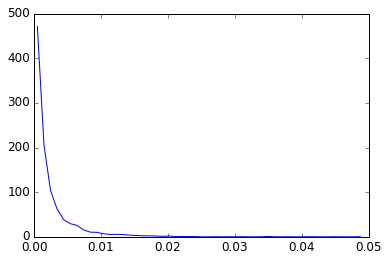

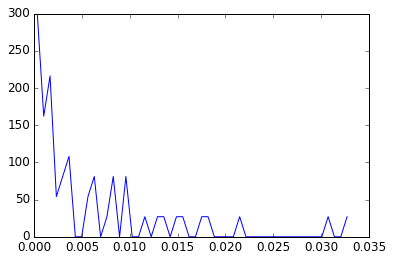

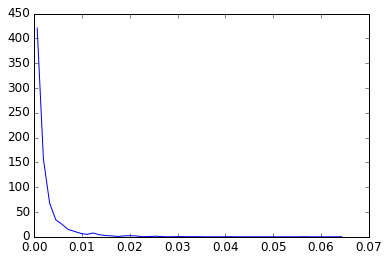

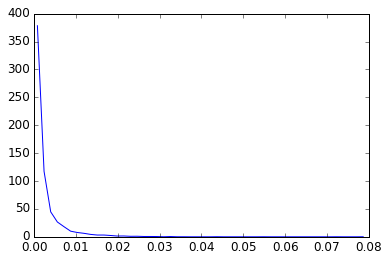

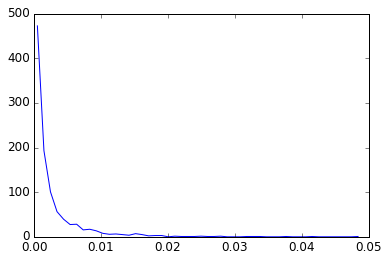

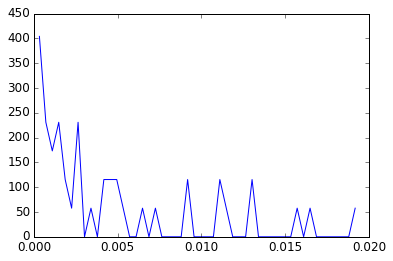

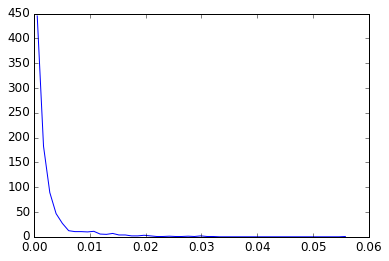

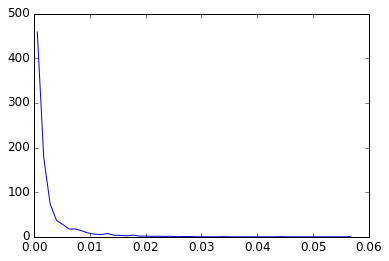

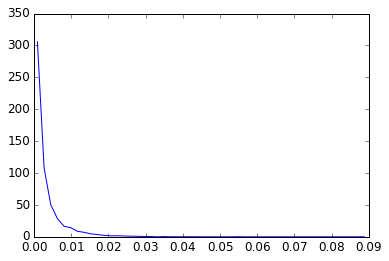

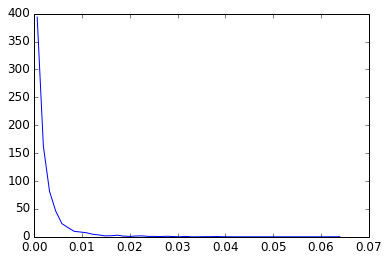

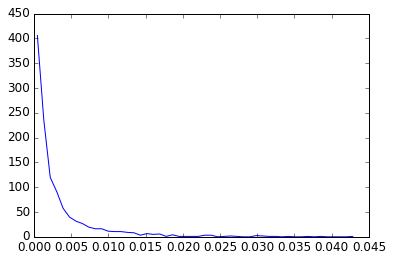

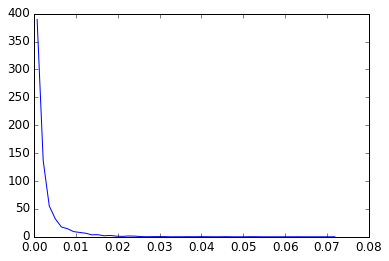

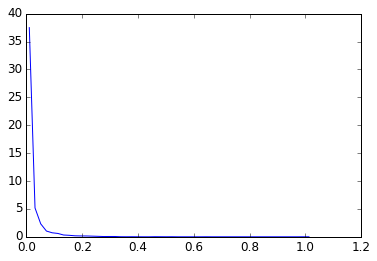

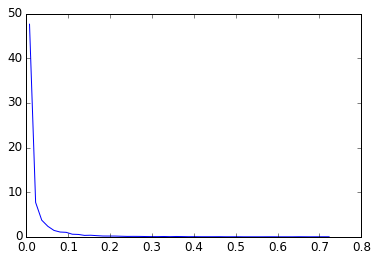

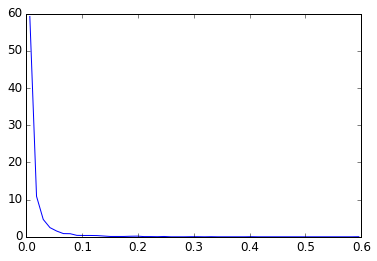

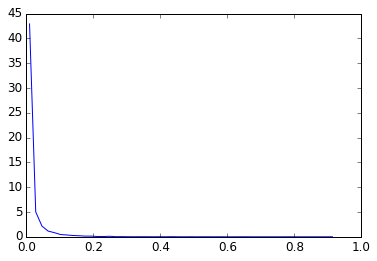

In [12]:
for imss in range(Nmss):
    for jmss in range(Nmss):
        if imss != jmss:
            plt.plot(msd_centers[imss][jmss],msd_hist[imss][jmss])
            plt.show()

In [13]:
def exp_func(x, a, c, d):
    return a*np.exp(-c*x)+d

In [14]:
x_val = [[[] for x in range(Nmss)] for y in range(Nmss)]
y_val = [[[] for x in range(Nmss)] for y in range(Nmss)]
p0 = (1, 1, 1)
y_opt = [[[] for x in range(Nmss)] for y in range(Nmss)]
y_cov = [[[] for x in range(Nmss)] for y in range(Nmss)]
for imss in range(Nmss):
    for jmss in range(Nmss):
        if imss != jmss:
            x_val[imss][jmss].append( msd_centers[imss][jmss] )
            y_val[imss][jmss].append( msd_hist[imss][jmss] )
            tmp_opt, tmp_cov = curve_fit(exp_func, x_val[imss][jmss][0], y_val[imss][jmss][0], p0=p0)
            y_opt[imss][jmss].append( tmp_opt )
            y_cov[imss][jmss].append( tmp_cov )

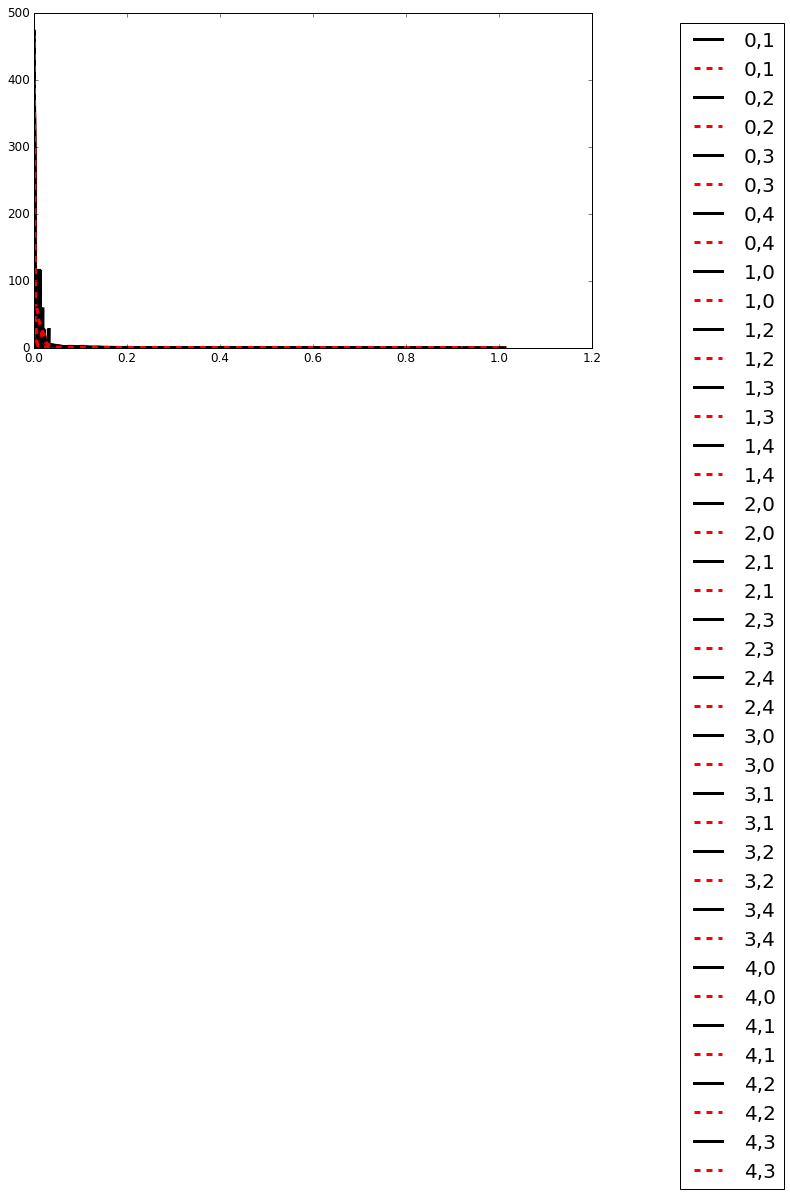

In [15]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
y_opt_vals = [[[] for x in range(Nmss)] for y in range(Nmss)]
for imss in range(Nmss):
    for jmss in range(Nmss):
        if imss != jmss:
            label = str(imss)+','+str(jmss)
            plt.plot(x_val[imss][jmss][0], y_val[imss][jmss][0],label=label,linewidth=3, color='k')
            y_opt_vals[imss][jmss].append( exp_func( x_val[imss][jmss][0], y_opt[imss][jmss][0][0], y_opt[imss][jmss][0][1], y_opt[imss][jmss][0][2] ) )
            plt.plot( x_val[imss][jmss][0], y_opt_vals[imss][jmss][0],label=label, linewidth=3, linestyle='--', color='r' )

plt.legend()
legend = plt.legend(fontsize='20',loc='upper center', bbox_to_anchor=(1.25, 1))
# frame = legend.get_frame()
# frame.set_linewidth('2.0')
# ltext = legend.get_texts()
# plt.setp(ltext, fontweight='bold')
# plt.xlim([-200,25000])
# plt.ylim([0,1.0])

In [16]:
y_val = np.array(y_val)
y_opt_vals = np.array(y_opt_vals)

In [17]:
ss_res = [[0. for x in range(Nmss)] for y in range(Nmss)]
ss_tot = [[0. for x in range(Nmss)] for y in range(Nmss)]
rsq = [[0. for x in range(Nmss)] for y in range(Nmss)]
for imss in range(Nmss):
    for jmss in range(Nmss):
        if imss != jmss:
            ss_res[imss][jmss] = np.sum( (y_val[imss][jmss][0]-y_opt_vals[imss][jmss][0])**2)
            ss_tot[imss][jmss] = numpy.sum(( np.subtract( y_val[imss][jmss][0], np.mean(y_val[imss][jmss][0])) )**2)
            rsq[imss][jmss] = 1. - ss_res[imss][jmss]/ss_tot[imss][jmss]

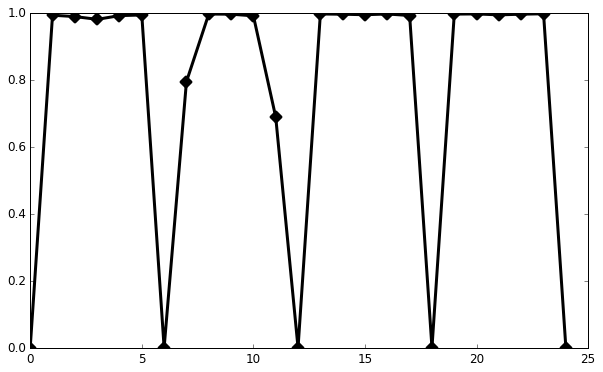

In [18]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plt.plot(np.concatenate(rsq),linewidth=3, color='k',marker='x',mew=10)
#plt.xticks(np.arange(len(rsq)),labels)
#plt.legend()
#legend = plt.legend(fontsize='20',loc='upper center', bbox_to_anchor=(1.25, 1))
# frame = legend.get_frame()
# frame.set_linewidth('2.0')
# ltext = legend.get_texts()
# plt.setp(ltext, fontweight='bold')
#plt.xlim([-200,25000])
#plt.ylim([0,1.0])

In [19]:
# repeat with the wait times

In [20]:
# wt = [[] for x in range(Nmss)]
# for proc in range(Nproc):
#     for imss in range(Nmss):
#         for val in wait_time_proc[proc][imss]:
#             wt[imss].append(val)

In [21]:
# wt_hist = [[] for x in range(Nmss)]
# wt_centers = [[] for x in range(Nmss)]
# for imss in range(Nmss):
#     wt_hist_tmp, wt_edges = np.histogram(wt[imss],bins=10,normed=1)
#     wt_hist[imss] = wt_hist_tmp
#     wt_centers[imss] = 0.5*(wt_edges[1:]+wt_edges[:-1]) 

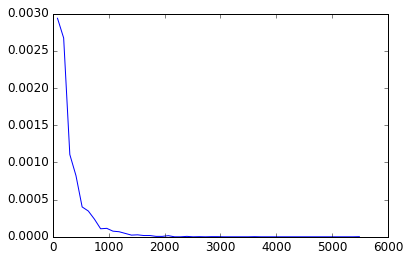

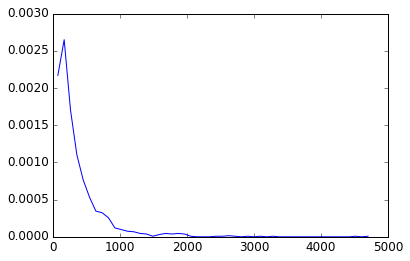

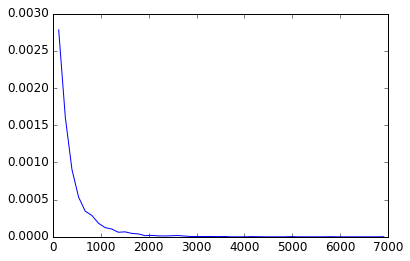

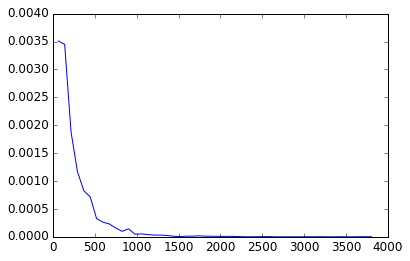

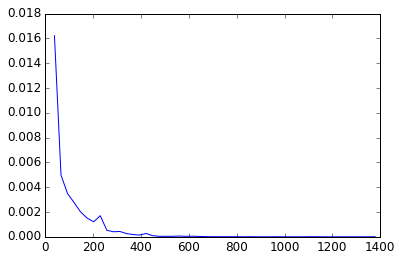

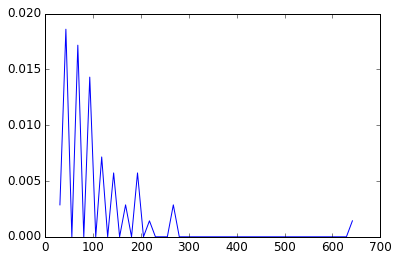

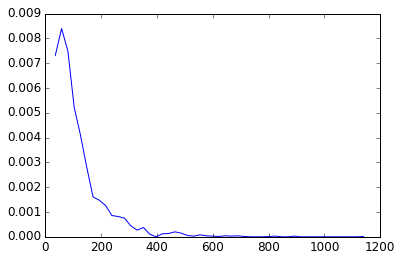

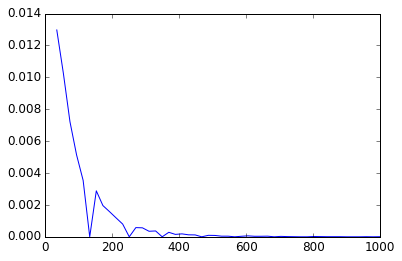

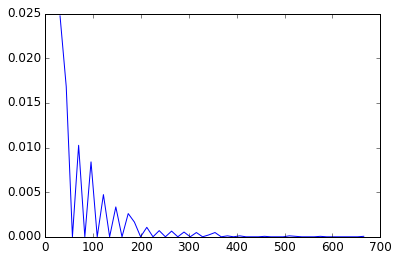

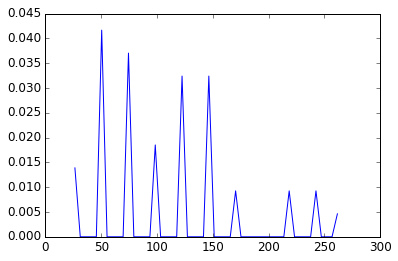

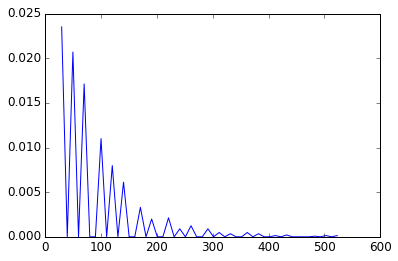

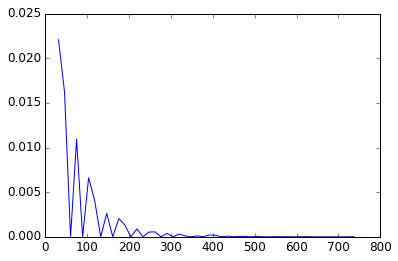

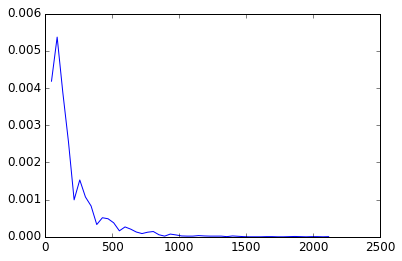

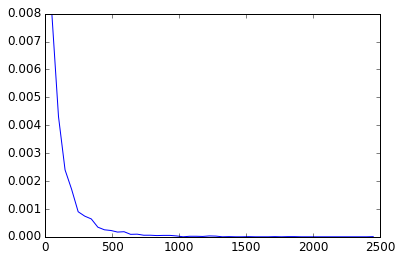

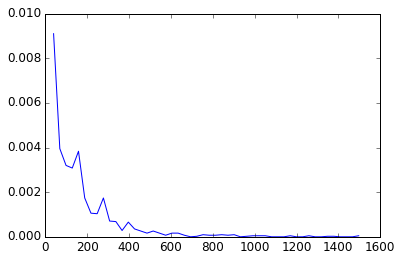

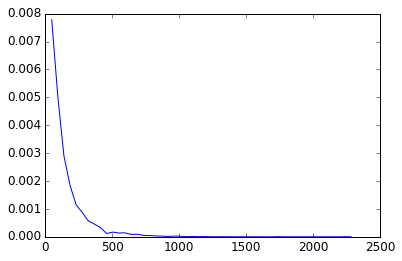

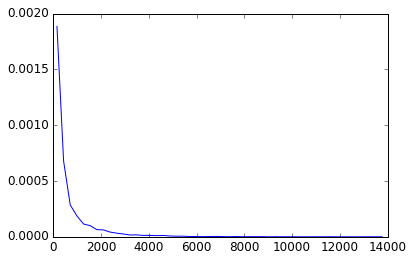

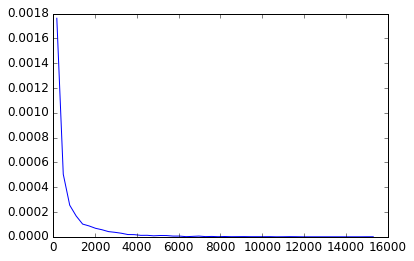

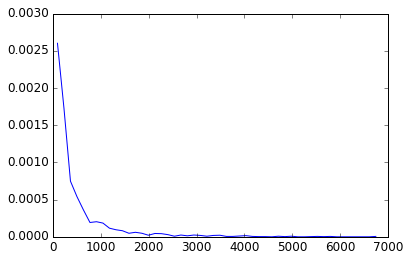

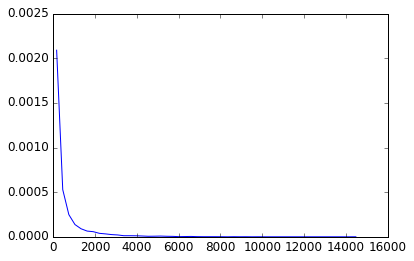

In [22]:
for imss in range(Nmss):
    for jmss in range(Nmss):
        if imss != jmss:
            plt.plot(wt_centers[imss][jmss],wt_hist[imss][jmss])
            plt.show()

In [23]:
# x_val_wt = [[] for x in range(Nmss)]
# y_val_wt = [[] for x in range(Nmss)]
# y_opt_wt = [[] for x in range(Nmss)]
# y_cov_wt = [[] for x in range(Nmss)]
# p0 = (0.0001, 0.0001, 0.0001)
# for imss in range(Nmss):
#     x_val_wt[imss].append( wt_centers[imss][1:] )
#     y_val_wt[imss].append( wt_hist[imss][1:] )
#     tmp_opt, tmp_cov = curve_fit(exp_func, x_val_wt[imss][0], y_val_wt[imss][0],p0=p0)
#     y_opt_wt[imss].append( tmp_opt )
#     y_cov_wt[imss].append( tmp_cov )

In [24]:
# fig = plt.figure(figsize=(10,6))
# ax = fig.add_subplot(111)
# y_opt_vals = [[[] for x in range(Nmss)] for y in range(Nmss)]
# for imss in range(Nmss):
#     for jmss in range(Nmss):
#         if imss != jmss:
#             label = str(imss)+','+str(jmss)
#             plt.plot(x_val[imss][jmss][0], y_val[imss][jmss][0],label=label,linewidth=3, color='k')
#             y_opt_vals[imss][jmss].append( exp_func( x_val[imss][jmss][0], y_opt[imss][jmss][0][0], y_opt[imss][jmss][0][1], y_opt[imss][jmss][0][2] ) )
#             plt.plot( x_val[imss][jmss][0], y_opt_vals[imss][jmss][0],label=label, linewidth=3, linestyle='--', color='r' )

# plt.legend()
# legend = plt.legend(fontsize='20',loc='upper center', bbox_to_anchor=(1.25, 1))
# frame = legend.get_frame()
# frame.set_linewidth('2.0')
# ltext = legend.get_texts()
# plt.setp(ltext, fontweight='bold')
# plt.xlim([-200,25000])
# plt.ylim([0,1.0])

In [25]:
# y_val_wt = np.array(y_val_wt)
# y_opt_vals_wt = np.array(y_opt_vals_wt)

In [26]:
# ss_res_wt = [0. for x in range(Nmss)]
# ss_tot_wt = [0. for x in range(Nmss)]
# rsq_wt = [0. for x in range(Nmss)]
# for imss in range(Nmss):
#     for jmss in range(Nmss):
#         ss_res_wt[imss] = np.sum( (y_val_wt[imss][0]-y_opt_vals_wt[imss][0])**2)
#         ss_tot_wt[imss] = numpy.sum(( np.subtract( y_val_wt[imss][0], np.mean(y_val_wt[imss][0])) )**2)
#         rsq_wt[imss] = 1. - ss_res_wt[imss]/ss_tot_wt[imss]

In [27]:
# fig = plt.figure(figsize=(10,6))
# ax = fig.add_subplot(111)
# plt.plot(rsq_wt,linewidth=3, color='k',marker='x',mew=10)
# ax.ticklabel_format(useOffset=False)
#plt.xticks(np.arange(len(rsq)),labels)
#plt.legend()
#legend = plt.legend(fontsize='20',loc='upper center', bbox_to_anchor=(1.25, 1))
# frame = legend.get_frame()
# frame.set_linewidth('2.0')
# ltext = legend.get_texts()
# plt.setp(ltext, fontweight='bold')
#plt.xlim([-200,25000])
#plt.ylim([0,1.0])

In [28]:
# try to calculate the diffusion constant, local D for each pair of states
msd_avg = np.zeros(shape=(Nmss,Nmss))
wt_avg = np.zeros(shape=(Nmss,Nmss))
for imss in range(Nmss):
    for jmss in range(Nmss):
        if imss != jmss:
            if (Tmle[imss][jmss]>7e-3):
                msd_avg[imss][jmss] = np.mean(msd[imss][jmss])
                wt_avg[imss][jmss] = np.mean(wt[imss][jmss])
            else:
                msd_avg[imss][jmss] = 0.
                wt_avg[imss][jmss] = 1.

In [29]:
D_loc = np.zeros(shape=(Nmss,Nmss))
for imss in range(Nmss):
    for jmss in range(Nmss):
        if imss != jmss:
            D_loc[imss][jmss] = msd_avg[imss][jmss] / (6*wt_avg[imss][jmss])
# nm / sample

In [30]:
traj = np.genfromtxt('../../dtraj_mss_concat_4states.dat').astype(int)

In [31]:
D = 0
Pimss = np.zeros(Nmss)
for imss in range(Nmss):
    Pimss[imss] = float(np.where(traj==imss)[0].shape[0]) / float(len(traj))
    for jmss in range(Nmss):        
        #D += Pimss[imss]*Tmle[imss][jmss]*D_loc[imss][jmss]
        D += mu[imss]*D_loc[imss][jmss]
D /= (Nmss-1.)
print Pimss
print mu

[ 0.59080672  0.06565343  0.17262623  0.17091362  0.        ]
[ 0.20488634  0.05418284  0.01520515  0.1052449   0.62048078]


In [32]:
D

4.2624651451588546e-06

In [33]:
D_unif = 0
for imss in range(Nmss):
    for jmss in range(Nmss):      
        D_unif += D_loc[imss][jmss]
D_unif /= float(Nmss*Nmss - Nmss)
D_unif

3.5795773727243056e-06

In [34]:
# cf direct from sim
D_sim = 0.0040 * (10**(-5)) # cm^2/s
D_sim *= 10**2 # nm^2 / sample
D_sim

4e-06

In [35]:
msd_avg

array([[ 0.        ,  0.00499429,  0.00646364,  0.0066507 ,  0.00545102],
       [ 0.00240772,  0.        ,  0.        ,  0.00241698,  0.00254976],
       [ 0.002742  ,  0.        ,  0.        ,  0.00260579,  0.00243099],
       [ 0.00319185,  0.00254062,  0.00326507,  0.        ,  0.00257165],
       [ 0.02046698,  0.02303989,  0.01478379,  0.01689629,  0.        ]])

In [36]:
wt_avg

array([[   0.        ,  293.93100564,  356.8317956 ,  405.33179191,
         261.06582118],
       [ 102.14480588,    0.        ,    1.        ,  111.3762466 ,
          97.7237911 ],
       [  79.2181693 ,    1.        ,    0.        ,   88.41580042,
          75.57780196],
       [ 202.63367485,  164.00122963,  169.88103569,    0.        ,
         139.91971665],
       [ 657.81346887,  755.02229055,  498.29184549,  574.69100335,    0.        ]])

In [37]:
D_loc

array([[  0.00000000e+00,   2.83189322e-06,   3.01899493e-06,
          2.73467119e-06,   3.47997582e-06],
       [  3.92860363e-06,   0.00000000e+00,   0.00000000e+00,
          3.61683579e-06,   4.34857895e-06],
       [  5.76888058e-06,   0.00000000e+00,   0.00000000e+00,
          4.91200112e-06,   5.36091022e-06],
       [  2.62530106e-06,   2.58191149e-06,   3.20329090e-06,
          0.00000000e+00,   3.06324198e-06],
       [  5.18560960e-06,   5.08591719e-06,   4.94482228e-06,
          4.90010750e-06,   0.00000000e+00]])

In [38]:
np.where(Tmle<5e-2)

(array([0, 1, 2, 3, 4, 4, 4, 4]), array([2, 2, 1, 2, 0, 1, 2, 3]))

In [39]:
Tmle[1][2]

0.0019496708746427371

In [40]:
Tmle[2][1]

0.0069475626173454647

In [41]:
np.savez('diff_info_avg.npz',msd_avg=msd_avg,wt_avg=wt_avg,D_loc=D_loc)